# Data Science Bowl: Exploratory Data Analysis & K-Means Clustering of Images

### Introduction

This year, Kaggle's Data Science Bowl covers segmentation of nuclei from microscope images. In this blog post we'll be covering some exploratory data analysis and try out some unsuperverised techniques for dealing with variation in the dataset.

In [23]:
# Just import some of the stuff will be using
import data_utils as dsb  # A utils python file written by us to work with the data
from skimage.io import imshow
from skimage.color import rgb2hsv
import matplotlib.pyplot as plt
import random
import numpy as np

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
NUM_CHANNELS = 3

PATH_TO_TRAIN = '../input/train/'
PATH_TO_TEST = '../input/test/'

NUM_TRAIN = 670
NUM_TEST = 65


## Training Data Exploration

In [20]:
# Load the training data
test_ids, X_test, sizes_test = dsb.load_test_data(path_to_test=PATH_TO_TEST, img_size=None,
                                                  num_channels=NUM_CHANNELS, mode='rgb')
train_ids, X_train, Y_train = dsb.load_train_data(path_to_train=PATH_TO_TRAIN, img_size=None,
                                                  num_channels=NUM_CHANNELS, mode='rgb')
print("Number of training samples: %s" % len(train_ids))
print("X-train shape: {}".format(X_train.shape))
print("Y-train shape: {}".format(Y_train.shape))
print("X-test shape: {}".format(X_test.shape))

# Combine the two sets
img_ids = np.concatenate([train_ids, test_ids], axis=0)
train_ids, test_ids = None, None
X_data = np.concatenate([X_train, X_test], axis=0)
Y_data = Y_train


100%|██████████| 670/670 [00:28<00:00, 23.76it/s]

Number of training samples: 670
X-train shape: (670,)
Y-train shape: (670,)
X-test shape: (65,)


In [21]:
print("Number ofa samples: %s" % len(img_ids))
print("X-data shape: {}".format(X_data.shape))

Number ofa samples: 735
X-data shape: (735,)


So we've loaded the data and see there are 670 training samples. For an image based problem, this isn't really that much and suggests we'll need to use some techiniques like data augmentation and regularization to combat the size of our dataset. Also note that we've loaded the images as 128x128 images with 3 (RGB) channels.

Let's take a look at a random sample just to get an idea of what these images might look like.

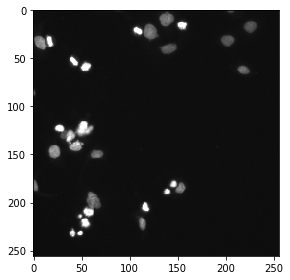

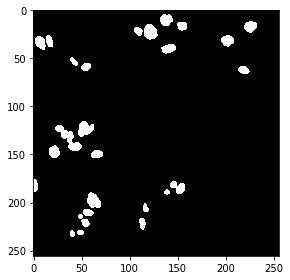

In [24]:
ix = random.randint(0, NUM_TRAIN)
imshow(X_data[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

So just by looking at this training sample and its respective mask, the nuclei look pretty well defined in the image. We have to be mindful that the above sample might not be representative of what all the training samples look like. Let's examine some more.

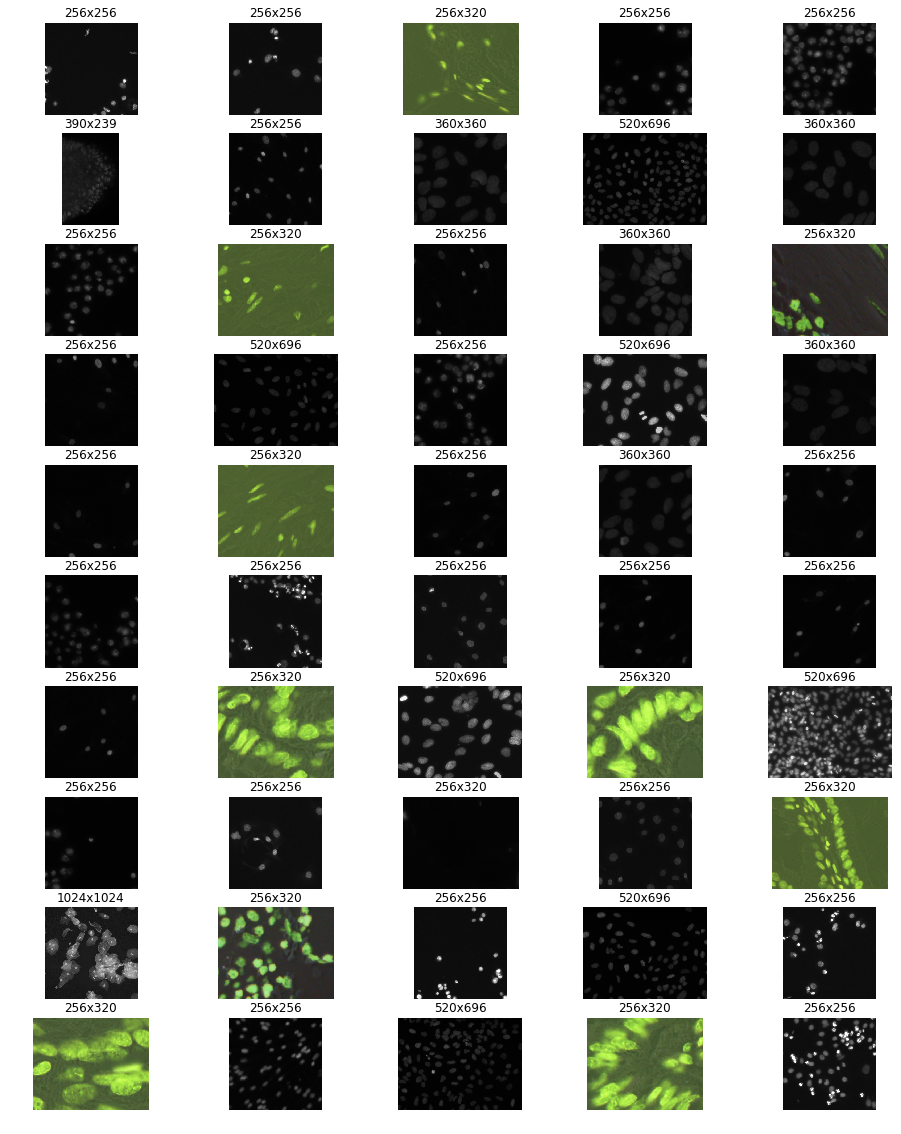

In [26]:
def plot_images(images, titles=None, images_rows=6, images_cols=8):
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
    for row in range(images_rows):
        for col in range(images_cols):
            if row*images_cols + col >= len(images):
                continue
            img_ind = row*images_cols + col
            img = images[img_ind]
            height, width, num_channels = img.shape
            img = np.squeeze(img)
            ax = axarr[row, col]
            ax.axis('off')
            img_title = "%dx%d"%(height, width)
            if titles is not None:
                img_title = titles[img_ind] + " - " + img_title
            ax.set_title(img_title)
            ax.imshow(img)

ixs = np.random.choice(len(img_ids), size=50, replace=False)
plot_images(X_data[ixs], images_rows=10, images_cols=5)
plt.show()

So we see in the above images that there seem to be 3 main types of images.
1) The images with the dark backgrounds and grayish nuclei. These are "fluorescent microscope images".
2) The images with purple nuclei and purple or light backgrounds. These are "histological microscope slides".
3) The images with transparent nuclei and light backgrounds. These are "bright-field microscope images".

Since we have 3 different kinds of images, it makes sense to try clustering the images into these 3 groups using an automated method like K-Means

### Running K-Means on the images

To use K-Means effectively, we'll need to use some tricks to deal with the high dimensionality of the images. Instead, we'll get the top 2 dominant colors (this should be the background color and foreground color) using K-Means on each image's pixels. We'll basically run the clustering algorithm for 2 clusters, which should hopefully pick out the background and foreground. Then we'll use these dominant clusters to characterize each image, and cluster the entire dataset into 3 clusters using K-Means. Let's get started.

In [27]:
from sklearn.cluster import KMeans
from tqdm import tqdm

def get_dominant_colors(img, top_colors=2):
    img_height, img_width, num_channels = img.shape
    img_l = img.reshape((img_height * img_width, num_channels))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist


# Get all the dominant colors
def get_all_dominant_colors(X, top_colors=1, mode="hsv"):
    dominant_colors = np.zeros((len(X), top_colors * NUM_CHANNELS))
    rates = []
    for i in tqdm(range(len(X))):
        img = X[i]
        if mode == "hsv":
            img = rgb2hsv(img)
        img_dominant, img_rates = get_dominant_colors(img, top_colors=top_colors)
        dominant_colors[i] = img_dominant.flatten()
        rates.append(img_rates)
    return dominant_colors, img_rates

Now we actually run the KMeans over the entire dataset

In [28]:
# Get the dominant colors and standaradize them
dominant_colors, img_rates = get_all_dominant_colors(X_data, top_colors=1, mode="hsv")
dominant_colors = dominant_colors - np.mean(dominant_colors)
dominant_colors = dominant_colors / np.std(dominant_colors)
kmeans = KMeans(n_clusters=3).fit(dominant_colors)
clusters = kmeans.predict(dominant_colors)

100%|██████████| 735/735 [04:31<00:00,  2.70it/s]


Now we look at cluster 0 (histological microscope slides):

Cluster 0 size: 615


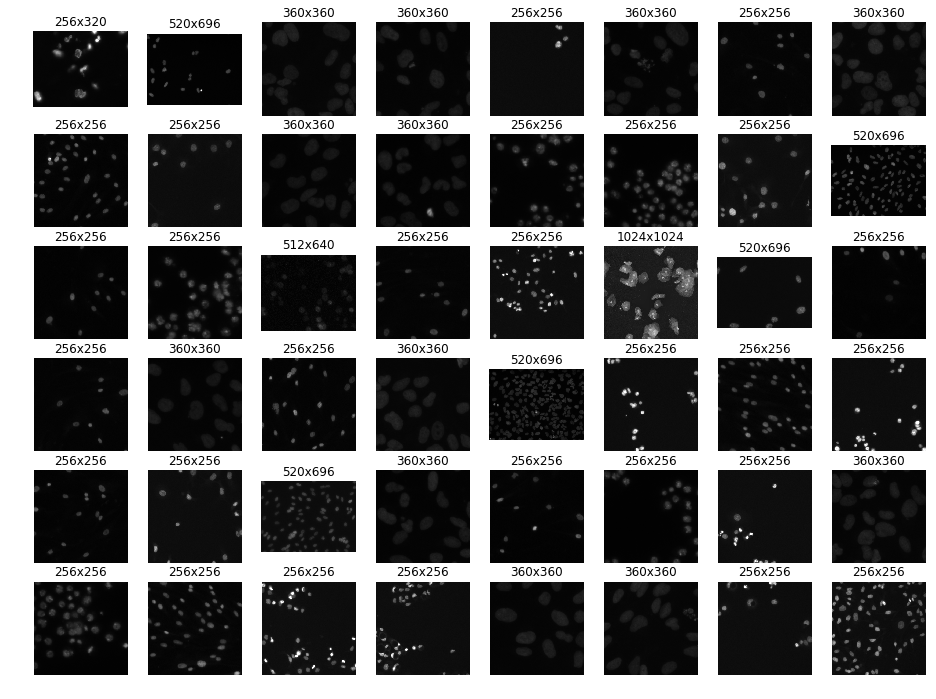

In [29]:
# Now examine the clusters (We'll only use the first 48)
img_cluster = X_data[clusters == 0]
print("Cluster 0 size: %s" % len(img_cluster))
plot_images(img_cluster, images_rows=6, images_cols=8)
plt.show()

Then we look at cluster 1 (fluorescent microscope images):

Cluster 1 size: 72


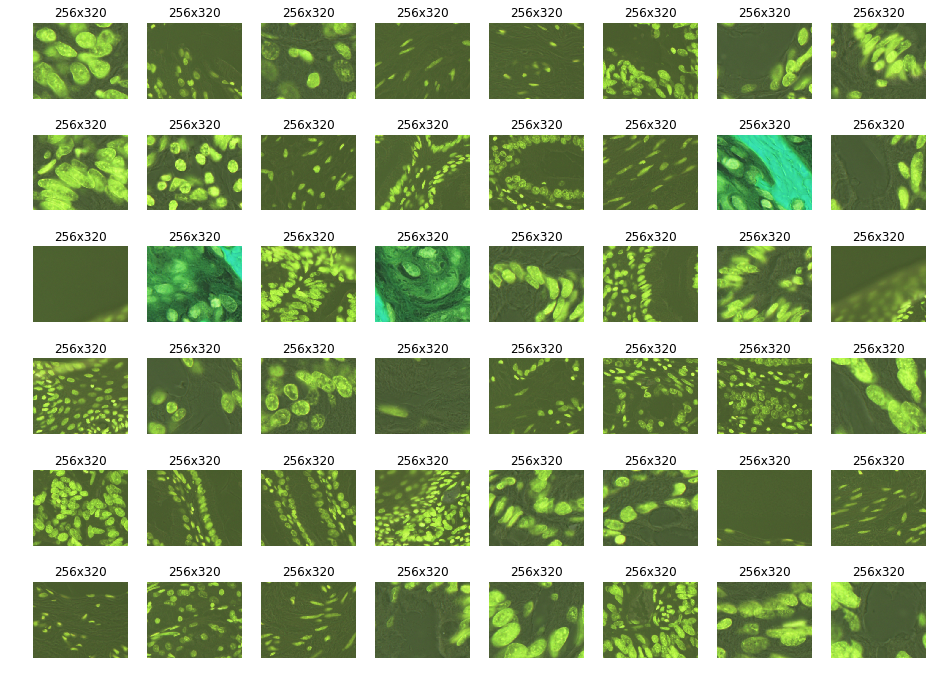

In [30]:
img_cluster = X_data[clusters == 1]
print("Cluster 1 size: %s" % len(img_cluster))
plot_images(img_cluster, images_rows=6, images_cols=8)
plt.show()

And finally cluster 2 (bright field images):

Cluster 2 size: 48


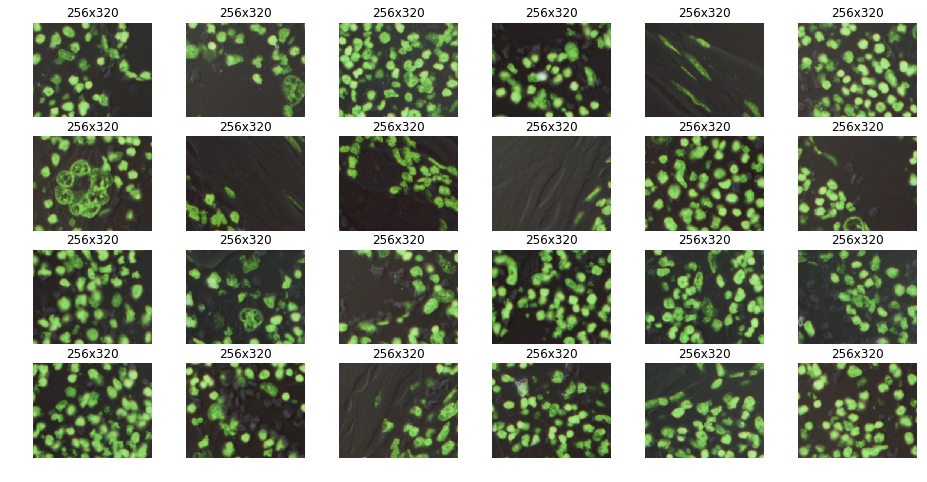

In [32]:
img_cluster = X_data[clusters == 2]
print("Cluster 2 size: %s" % len(img_cluster))
plot_images(img_cluster, images_rows=4, images_cols=6)
plt.show()

In [37]:
import os
from utils import safe_open_dir

# Save the ids of the clusters
train_ids = img_ids[:NUM_TRAIN]
test_ids = img_ids[NUM_TRAIN:]

train_clusters = clusters[:NUM_TRAIN]
test_clusters = clusters[NUM_TRAIN:]

# Save the ids of the clusters
np.savez(os.path.join(safe_open_dir("../clusters"), "train_clusters.npz"), 
         cluster_0=train_ids[train_clusters == 0],
         cluster_1=train_ids[train_clusters == 1],
         cluster_2=train_ids[train_clusters == 2])

np.savez(os.path.join(safe_open_dir("../clusters"), "test_clusters.npz"), 
         cluster_0=test_ids[test_clusters == 0],
         cluster_1=test_ids[test_clusters == 1],
         cluster_2=test_ids[test_clusters == 2])

### Some Comments on these clusters

The fluorescent image and histologic slide clusters seem pretty good. The bright field cluster however brought in some similar looking histologic slides. We might be able to improve this my using only 1 dominant color (like in [MPWare Team's Kernel](https://www.kaggle.com/mpware/stage1-eda-microscope-image-types-clustering) instead of the two dominant colors to produce better clusters.

However, main takeaway is that this technique gives a fairly efficient automated method to properly split our data into its different constituents. Once we start training models, we can try training different models for each type of microscope image to see if this improves our performance.